In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

plt.style.use('ggplot')

# PyMC3

In [2]:
import pymc3 as pm
from theano import shared
import theano.tensor as tt

Using cuDNN version 7003 on context None
Mapped name None to device cuda: GeForce GTX 1080 Ti (0000:01:00.0)


In [3]:
mat = scipy.io.loadmat('data/olympics.mat')
olympics = mat['male100'][:, :2]

In [4]:
datx = olympics[:,0]
daty = olympics[:,1]

meanx = datx.mean()
stdx = datx.std()
meany = daty.mean()
stdy = daty.std()
datx = (datx-meanx)/stdx
daty = (daty-meany)/stdy
x_train = datx.astype(np.float32).reshape((-1, 1))
y_train = daty.astype(np.float32)

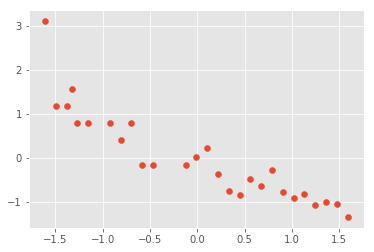

In [5]:
plt.scatter(x_train, y_train)

In [6]:
n_hidden = 2

with pm.Model() as nn_model:
    w1 = pm.Normal('w1', mu=0, sd=10, shape=(1, n_hidden))
    w2 = pm.Normal('w2', mu=0, sd=10, shape=(n_hidden, 1))

    b1 = pm.Normal('b1', mu=0, sd=10, shape=(n_hidden,))
    b2 = pm.Normal('b2', mu=0, sd=10, shape=(1,))

    a1 = pm.Deterministic('a1', tt.nnet.relu(pm.math.dot(x_train, w1) + b1))
    a2 = pm.Deterministic('a2', pm.math.dot(a1, w2) + b2)
    
    output = pm.Normal('likelihood', mu=tt.reshape(a2, [-1]), observed=y_train)

In [7]:
with nn_model:
    trace = pm.sample(1000, njobs=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [b2, b1, w2, w1]
100%|██████████| 1500/1500 [00:40<00:00, 36.76it/s]
There were 102 divergences after tuning. Increase `target_accept` or reparameterize.
There were 176 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.669657804587, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [7]:
with nn_model:
    approx = pm.fit(n=10000)

Average Loss = 57.192: 100%|██████████| 10000/10000 [00:06<00:00, 1495.51it/s]
Finished [100%]: Average Loss = 57.186


In [8]:
with nn_model:
    trace = approx.sample(draws=1000)

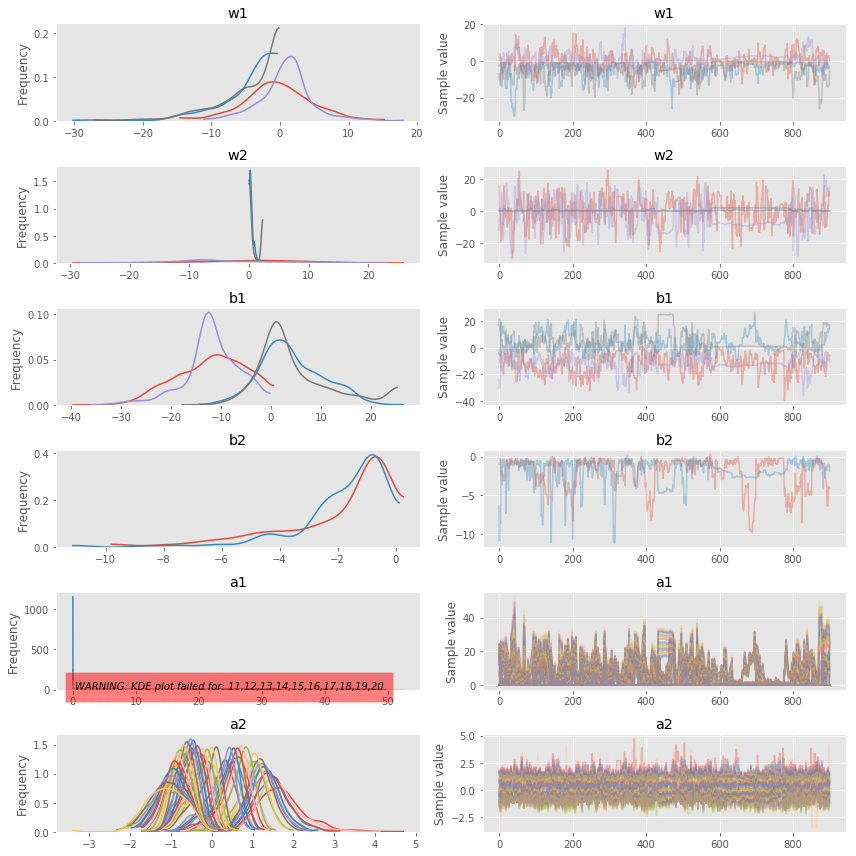

In [8]:
pm.traceplot(trace[100:])
plt.tight_layout();

In [9]:
ppc = pm.sample_ppc(trace, model=nn_model, samples=50)

100%|██████████| 50/50 [00:00<00:00, 927.37it/s]


In [10]:
#std = np.std(ppc['likelihood'], 0)
mean = np.mean(ppc['likelihood'], 0)

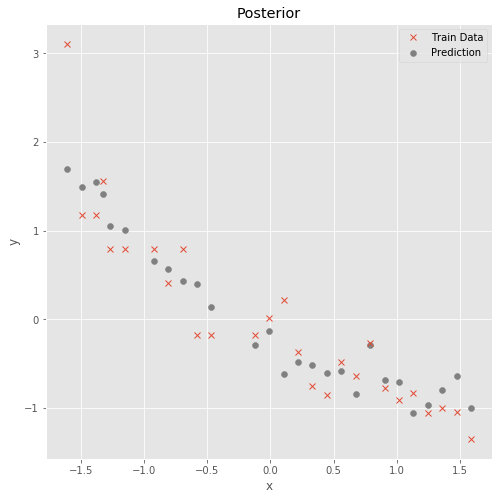

In [11]:
plt.figure(figsize=(8, 8))
plt.scatter(x_train, mean, c='grey', label='Prediction')

plt.plot(x_train, y_train, 'x', label='Train Data')

plt.title('Posterior')
plt.legend(loc=0)
plt.xlabel('x')
plt.ylabel('y')

plt.show()

In [12]:
mse(y_train, ppc['likelihood'].mean(axis=0))

0.15941110288142143

## Edward

In [6]:
import edward as ed
import tensorflow as tf
from edward.models import Normal

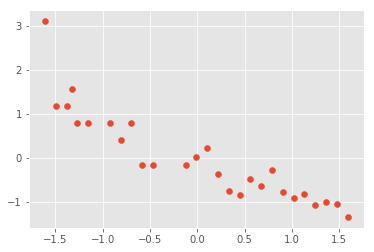

In [7]:
N = datx.shape[0]  # number of data ponts
D = 1   # number of features

plt.scatter(x_train, y_train)

In [8]:
def neural_network(x, W_0, W_1, b_0, b_1):
  h = tf.nn.relu(tf.matmul(x, W_0) + b_0)
  h = tf.matmul(h, W_1) + b_1
  return tf.reshape(h, [-1])

In [9]:
W_0 = Normal(loc=tf.zeros([D, 2]), scale=tf.ones([D, 2]))
W_1 = Normal(loc=tf.zeros([2, 1]), scale=tf.ones([2, 1]))
b_0 = Normal(loc=tf.zeros(2), scale=tf.ones(2))
b_1 = Normal(loc=tf.zeros(1), scale=tf.ones(1))

x = x_train
y = Normal(loc=neural_network(x, W_0, W_1, b_0, b_1),
           scale=0.1 * tf.ones(N))


In [10]:
qW_0 = Normal(loc=tf.get_variable("qW_0/loc", [D, 2]),
              scale=tf.nn.softplus(tf.get_variable("qW_0/scale", [D, 2])))
qW_1 = Normal(loc=tf.get_variable("qW_1/loc", [2, 1]),
              scale=tf.nn.softplus(tf.get_variable("qW_1/scale", [2, 1])))
qb_0 = Normal(loc=tf.get_variable("qb_0/loc", [2]),
              scale=tf.nn.softplus(tf.get_variable("qb_0/scale", [2])))
qb_1 = Normal(loc=tf.get_variable("qb_1/loc", [1]),
              scale=tf.nn.softplus(tf.get_variable("qb_1/scale", [1])))


In [11]:
inference = ed.KLqp({W_0: qW_0, b_0: qb_0,
                     W_1: qW_1, b_1: qb_1}, data={y: y_train})
inference.run(n_iter=1000, n_samples=50)

1000/1000 [100%] ██████████████████████████████ Elapsed: 17s | Loss: 250.564


In [12]:
mus = tf.stack(
    [neural_network(x_train, qW_0.sample(), qW_1.sample(),
                    qb_0.sample(), qb_1.sample())
     for _ in range(10)])

In [13]:
outputs = mus.eval()

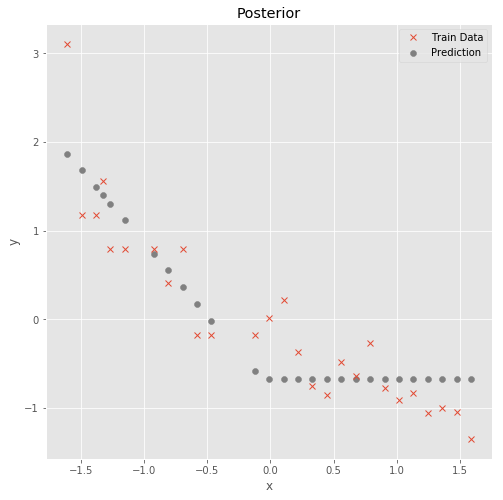

In [14]:
plt.figure(figsize=(8, 8))
plt.scatter(x_train, np.mean(outputs, axis=0), c='grey', label='Prediction')

plt.plot(x_train, y_train, 'x', label='Train Data')

plt.title('Posterior')
plt.legend(loc=0)
plt.xlabel('x')
plt.ylabel('y')

plt.show()

In [15]:
mse(y_train, outputs[0].T)

0.20007271